# NBA DRAFT

Testing if Git server extension works

# Imports

In [22]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
import random
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
!pip install lightgbm
from lightgbm.sklearn import LGBMClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, recall_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Merge and Clean Dataset

In [2]:
df_adv = pd.read_csv("data/NBA 2025 Advanced Stats.csv")
df_adv = df_adv[["Rk", "Player", "PER", "WS/48", "BPM", "VORP▼"]]
df_adv.rename(columns={"VORP▼": "VORP"}, inplace=True) 
df_adv["Player"] = df_adv["Player"].str.strip()
df_adv.head()

# Step 2: Load and combine all draft datasets from 2018 to 2024
dfs_draft = []
for year in range(2018, 2025):
    df_draft = pd.read_csv(f"data/{year} NBA Draft Board.csv")
    df_draft["DraftYear"] = year
    df_draft["Player"] = df_draft["Player"].str.strip()
    dfs_draft.append(df_draft)

df_all_drafts = pd.concat(dfs_draft, ignore_index=True)

# Step 3: Merge on Player name (inner join)
df = pd.merge(df_adv, df_all_drafts, on="Player", how="inner")

# Preview the result
df.head()

,Rk,Player,PER,WS/48,BPM,VORP,Age,Team,League,Pos,...,STL,BLK,TOV,PF,PTS,Height,Weight,Wingspan,DraftPos,DraftYear
0,2,Shai Gilgeous-Alexander,30.7,0.309,11.5,8.9,19,Kentucky,NCAA,G,...,1.6,0.5,2.7,1.7,14.4,76.50,180.0,83.50,11,2018
1,4,Tyrese Haliburton,21.8,0.204,5.8,4.9,20,Iowa State,NCAA,G,...,2.5,0.7,2.8,1.3,15.2,76.75,175.0,79.75,12,2020
2,8,Anthony Edwards,20.1,0.140,4.3,4.6,18,Georgia,NCAA,G,...,1.3,0.6,2.7,2.2,19.1,76.00,225.0,81.00,1,2020
3,11,Luka Dončić,24.1,0.160,6.7,3.9,19,Real Madrid,EuroLeague,G,...,1.1,0.3,2.3,1.5,16.0,78.50,218.0,83.00,3,2018
4,13,Cade Cunningham,20.6,0.115,3.9,3.7,19,Oklahoma State,NCAA,G,...,1.6,0.8,4.0,2.5,20.1,80.00,220.0,84.00,1,2021


In [3]:
print(df.columns)

df = df[['Rk', 'Player', 'PER', 'WS/48', 'BPM', 'VORP', 'Age', 'Team', 'League', 'Pos', 'G', 'MP', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Height', 'Weight', 'Wingspan', 'DraftPos', 'DraftYear']]
df.head()

#For Undrafted Players, assign them with integer 61 to keep ordinal ordering
df['DraftPos'] = df['DraftPos'].replace('Undrafted', 61)
df['DraftPos'] = df['DraftPos'].astype(int)

Index(['Rk', 'Player', 'PER', 'WS/48', 'BPM', 'VORP', 'Age', 'Team', 'League',
       'Pos', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'Height', 'Weight', 'Wingspan', 'DraftPos',
       'DraftYear'],
      dtype='object')


# Code Model

## Split Training and Testing Data

In [4]:
train_df, test_df = train_test_split(df, test_size=0.30, random_state=123)
train_df.head()

,Rk,Player,PER,WS/48,BPM,VORP,Age,Team,League,Pos,...,STL,BLK,TOV,PF,PTS,Height,Weight,Wingspan,DraftPos,DraftYear
190,361,Terrence Shannon Jr.,11.9,0.091,-2.1,0.0,23,Illinois,NCAA,G,...,1.0,0.9,2.0,2.2,23.0,77.75,219.4,80.75,27,2024
89,173,Matisse Thybulle,17.0,0.146,5.0,0.6,22,Washington,NCAA,G,...,3.5,2.3,1.8,2.8,9.1,77.00,195.0,83.50,20,2019
21,45,Dyson Daniels,15.6,0.093,1.5,2.3,19,IGN,G League,G,...,2.0,0.7,2.7,2.2,11.6,78.00,195.2,82.50,8,2022
125,235,Josh Minott,15.5,0.153,2.2,0.3,19,Memphis,NCAA,G,...,0.8,0.7,0.9,1.8,6.6,79.50,205.0,83.75,45,2022
212,403,Jaden Springer,10.7,0.070,-2.7,-0.1,18,Tennessee,NCAA,G,...,1.2,0.4,2.4,2.0,12.5,75.00,202.0,79.75,28,2021


## EDA

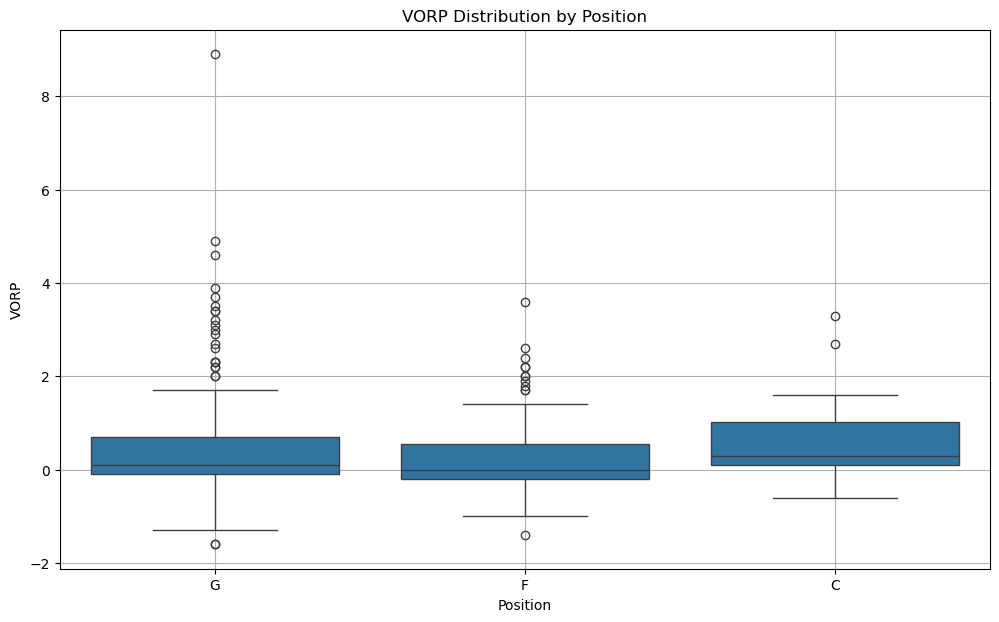

In [5]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='Pos', y='VORP')

plt.title('VORP Distribution by Position')
plt.xlabel('Position')
plt.ylabel('VORP')
plt.grid(True)
plt.show()

## Preprocessing and Transformations

In [6]:
print(df.columns)

df.dtypes

Index(['Rk', 'Player', 'PER', 'WS/48', 'BPM', 'VORP', 'Age', 'Team', 'League',
       'Pos', 'G', 'MP', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Height', 'Weight', 'Wingspan', 'DraftPos', 'DraftYear'],
      dtype='object')


Rk             int64
Player        object
PER          float64
WS/48        float64
BPM          float64
VORP         float64
Age            int64
Team          object
League        object
Pos           object
G              int64
MP           float64
eFG%         float64
FT%          float64
TRB          float64
AST          float64
STL          float64
BLK          float64
TOV          float64
PF           float64
PTS          float64
Height       float64
Weight       float64
Wingspan     float64
DraftPos       int64
DraftYear      int64
dtype: object

In [15]:
numerical_features = ["PER", "WS/48", "BPM", "Age", "G", "MP", "eFG%", "FT%", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "Height", "Weight", "Wingspan", "DraftPos"]

categorical_features = ["Team", "League", "Pos"]

drop_features = ["Player", "DraftYear"]

target = ["Rk"]

In [16]:
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')

preprocessor = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features), 
    ('drop', drop_features),
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['PER', 'WS/48', 'BPM', 'Age', 'G', 'MP',
                                  'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK',
                                  'TOV', 'PF', 'PTS', 'Height', 'Weight',
                                  'Wingspan', 'DraftPos']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Team', 'League', 'Pos']),
                                ('drop', 'drop', ['Player', 'DraftYear'])])

## LASSO

In [24]:
train_df, test_df = train_test_split(df, test_size=0.30, random_state=123)
train_df.head()


X_train = train_df.drop(['VORP'], axis = 1)
y_train = train_df['VORP']
X_test = test_df.drop(['VORP'], axis = 1)
y_test = test_df['VORP']

In [26]:
# Create Model pipeline
pipe_lasso = make_pipeline(preprocessor, Lasso(max_iter=10000))

# Specify Param Grid
param_grid_lasso = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Grid Search CV
grid_search_lasso = GridSearchCV(
    pipe_lasso,
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',  # Use MSE or another regression metric
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

# Fit Model
grid_search_lasso.fit(X_train, y_train)

# View Results
lasso_df_sorted = pd.DataFrame(grid_search_lasso.cv_results_)[
    [
        "mean_test_score",
        "std_test_score",
        "mean_fit_time",
        'param_lasso__alpha'
    ]
].sort_values(
    by=["mean_test_score"],
    ascending=False
).T

In [27]:
lasso_df_sorted

,2,3,1,0,4,5,6
mean_test_score,-0.681194,-0.691344,-1.043275,-1.228374,-1.365123,-1.365123,-1.365123
std_test_score,0.255116,0.274248,0.416050,0.454398,0.636507,0.636507,0.636507
mean_fit_time,0.126256,0.072865,0.107501,0.022677,0.008987,0.009385,0.008596
param_lasso__alpha,0.010000,0.100000,0.001000,0.000100,1.000000,10.000000,100.000000


## Hyperparameter Optimization

## Test Model on Unseen Data

# References

Basketball Reference

Sports Reference

NBADraft.net